# BinConv Training Example: Sequence-to-One Prediction

This notebook demonstrates proper BinConv training using **sequence-to-one** prediction, where:
- **Training**: The model learns to predict the next single value given a context window
- **Inference**: Multi-step forecasting is achieved through autoregressive generation

This is the correct approach for BinConv models, as they are designed for single-step prediction during training and use autoregressive generation for longer forecasts.

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from binconvfm.models.binconv import LightningBinConv
from pytorch_lightning import Trainer

print("📦 Simple BinConv training setup ready!")

📦 Simple BinConv training setup ready!


## Generate Simple Time Series with Small Gaussian Noise

📈 Generated time series:
   Length: 256
   Mean: 192.250
   Std: 110.855
   Context length: 32
   Forecast steps (testing): 32
   ✅ Training approach: sequence-to-one prediction


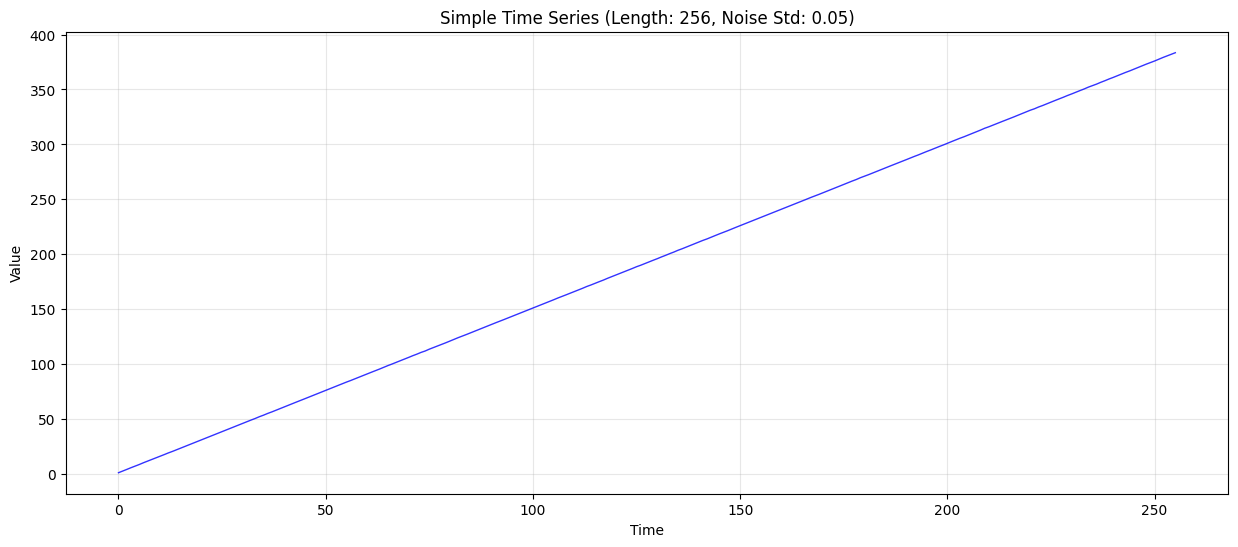

In [11]:
# Configuration
context_length = 32
forecast_steps = 32  # Number of steps to forecast (for testing only)
total_length = 256  # Total time series length
noise_std = 0.05  # Small Gaussian noise

def generate_simple_time_series(length, noise_std):
    """Generate a single time series with linear trend and small Gaussian noise."""
    t = np.arange(length)
    
    # Simple linear trend with gentle slope
    trend = 1.5 * t + 1.0
    
    # Add small Gaussian noise
    noise = np.random.normal(0, noise_std, length)
    
    # Combine trend and noise
    series = trend + noise
    
    return series

# Generate the single time series
np.random.seed(42)  # For reproducibility
time_series = generate_simple_time_series(total_length, noise_std)

print(f"📈 Generated time series:")
print(f"   Length: {len(time_series)}")
print(f"   Mean: {time_series.mean():.3f}")
print(f"   Std: {time_series.std():.3f}")
print(f"   Context length: {context_length}")
print(f"   Forecast steps (testing): {forecast_steps}")
print(f"   ✅ Training approach: sequence-to-one prediction")

# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(time_series, 'b-', alpha=0.8, linewidth=1)
plt.title(f'Simple Time Series (Length: {total_length}, Noise Std: {noise_std})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

## Create Dataset for Sequence-to-One Training

The key fix: **targets are now single values, not sequences**

In [12]:
class SimpleTimeSeriesDataset(Dataset):
    """
    Dataset that creates sliding windows from a single time series.
    
    Each sample consists of:
    - Input: context_length time steps
    - Target: SINGLE next value (sequence-to-one prediction)
    """
    
    def __init__(self, time_series, context_length):
        self.time_series = torch.FloatTensor(time_series)
        self.context_length = context_length
        
        # Calculate number of valid windows (need 1 extra step for target)
        self.num_samples = len(time_series) - context_length
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Input: context_length time steps
        input_seq = self.time_series[idx:idx + self.context_length].unsqueeze(-1)  # (context_length, 1)
        
        # Target: just the NEXT single value
        target_value = self.time_series[idx + self.context_length].unsqueeze(-1)  # (1,)
        
        return input_seq, target_value

# Create datasets
train_split = int(0.8 * total_length)  # Use 80% for training
train_series = time_series[:train_split]
val_series = time_series[train_split:]

train_dataset = SimpleTimeSeriesDataset(train_series, context_length)
val_dataset = SimpleTimeSeriesDataset(val_series, context_length)

print(f"📊 Dataset Statistics:")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")

# Check sample shapes
sample_input, sample_target = train_dataset[0]
print(f"   Sample input shape: {sample_input.shape}")
print(f"   Sample target shape: {sample_target.shape}")

# Show a few samples
print(f"\n🔍 Sample Data (first 3 samples):")
for i in range(3):
    input_seq, target_val = train_dataset[i]
    print(f"   Sample {i}: input[0]={input_seq[0].item():.3f}, target={target_val.item():.3f}")
    
print(f"\n✅ Fixed: Now using sequence-to-one prediction!")
print(f"   - Input: {context_length} historical values")
print(f"   - Target: 1 next value to predict")

📊 Dataset Statistics:
   Training samples: 172
   Validation samples: 20
   Sample input shape: torch.Size([32, 1])
   Sample target shape: torch.Size([1])

🔍 Sample Data (first 3 samples):
   Sample 0: input[0]=1.025, target=48.999
   Sample 1: input[0]=2.493, target=50.447
   Sample 2: input[0]=4.032, target=52.041

✅ Fixed: Now using sequence-to-one prediction!
   - Input: 32 historical values
   - Target: 1 next value to predict



## Initialize Simple BinConv Model

In [13]:
# Simple model configuration
num_bins = 512 # Smaller number of bins for simplicity
min_bin_value = -5.0
max_bin_value = 5.0
learning_rate = 1e-1

# Initialize BinConv model for sequence-to-one prediction
model = LightningBinConv(
    context_length=context_length,
    is_prob_forecast=True,
    num_bins=num_bins,
    min_bin_value=min_bin_value,
    max_bin_value=max_bin_value,
    num_filters_2d=context_length,  # Smaller for simplicity
    num_filters_1d=context_length,
    num_blocks=1,  # Single block for simplicity
    kernel_size_ffn=51,
    dropout=0.0,
    scaler_type='standard',  # Use standard scaling
    last_layer = 'conv',
    lr=learning_rate
)

total_params = sum(p.numel() for p in model.parameters())
print(f"🧠 Simple BinConv Model (Sequence-to-One):")
print(f"   Parameters: {total_params:,}")
print(f"   Context length: {context_length}")
print(f"   Prediction steps: 1 (single-step prediction)")
print(f"   Number of bins: {num_bins}")
print(f"   Learning rate: {learning_rate}")
print(f"   ✅ Model configured for proper sequence-to-one training")

🧠 Simple BinConv Model (Sequence-to-One):
   Parameters: 5,123
   Context length: 32
   Prediction steps: 1 (single-step prediction)
   Number of bins: 512
   Learning rate: 0.1
   ✅ Model configured for proper sequence-to-one training


In [14]:
# Simple training setup
batch_size = 128
num_epochs = 100

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"🚂 Training Setup:")
print(f"   Batch size: {batch_size}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Epochs: {num_epochs}")

# Simple trainer
trainer = Trainer(
    max_epochs=num_epochs,
    accelerator='cpu',
    enable_progress_bar=True,
    log_every_n_steps=10,
    enable_checkpointing=False,
    logger=False
)

# Train the model
print(f"\\n🏃 Starting simple training...")
trainer.fit(model, train_loader, val_loader)
print(f"✅ Training completed!")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | dropout | Dropout    | 0      | train
1 | act     | ModuleList | 65     | train
2 | layers  | ModuleDict | 5.1 K  | train
-----------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


🚂 Training Setup:
   Batch size: 128
   Training batches: 2
   Validation batches: 1
   Epochs: 100
\n🏃 Starting simple training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


✅ Training completed!


## Test Multi-Step Autoregressive Forecasting

Now the model can properly forecast multiple steps ahead using autoregressive generation:

🧪 Testing Multi-Step Forecasting:
   Context length: 32
   Forecast steps: 32
   Input shape: torch.Size([1, 32, 1])
   Forecast shape: torch.Size([1, 1, 1, 32])
   Extracted predictions shape: (32,)


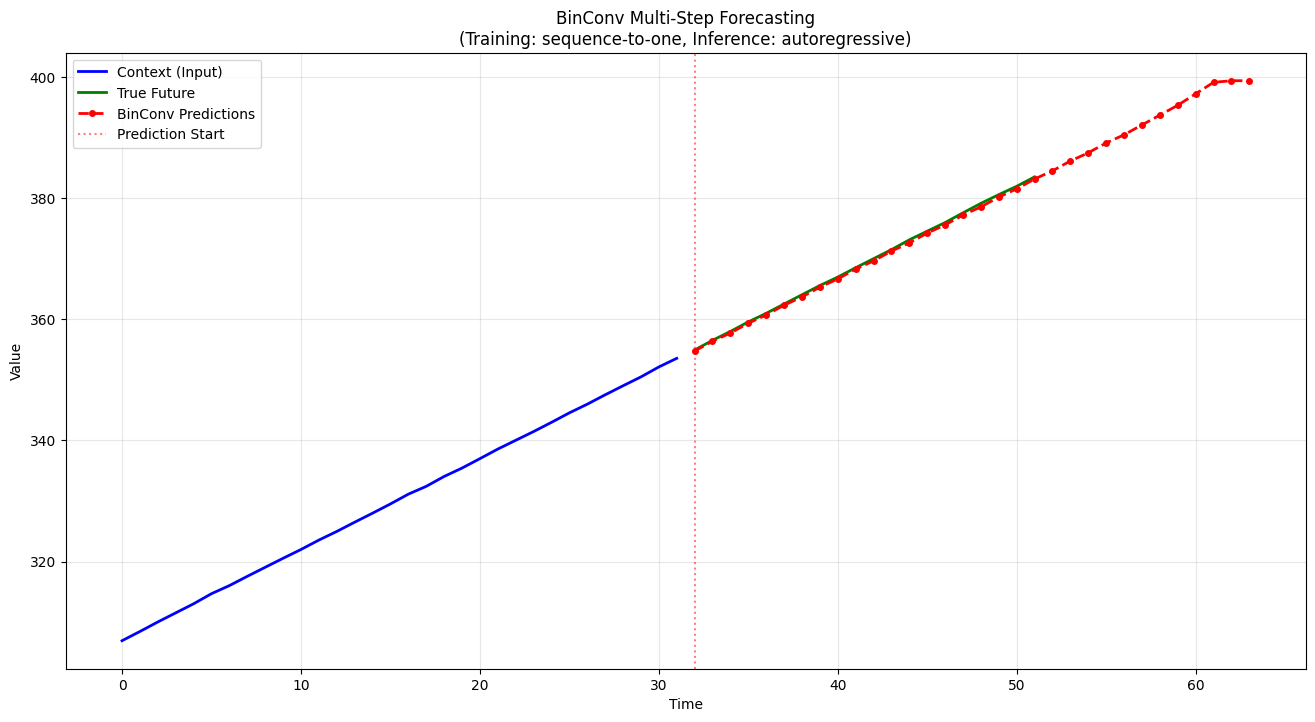


🎯 BinConv Training Fixed!
   ✅ Training: sequence-to-one (context → single next value)
   ✅ Inference: autoregressive multi-step forecasting
   ✅ Proper shape handling: inputs torch.Size([1, 32, 1]) → forecasts torch.Size([1, 1, 1, 32])
   ✅ Model learns single-step prediction, then chains for multi-step


In [15]:
# Test the model on a portion of the time series
forecast_steps = 32  # Number of steps to forecast ahead
test_start = train_split
test_context = time_series[test_start:test_start + context_length]
test_true = time_series[test_start + context_length:test_start + context_length + forecast_steps]

# Prepare input for model
test_input = torch.FloatTensor(test_context).unsqueeze(0).unsqueeze(-1)  # (1, context_length, 1)

print(f"🧪 Testing Multi-Step Forecasting:")
print(f"   Context length: {len(test_context)}")
print(f"   Forecast steps: {forecast_steps}")
print(f"   Input shape: {test_input.shape}")

# Make prediction using autoregressive forecasting
model.eval()
with torch.no_grad():
    # Use forecast method for multi-step prediction (this does autoregressive generation)
    forecasts = model.forecast(test_input, prediction_length=forecast_steps, num_samples=1)
    print(f"   Forecast shape: {forecasts.shape}")

# Visualize results
plt.figure(figsize=(16, 8))

# Plot context
context_x = np.arange(len(test_context))
plt.plot(context_x, test_context, 'b-', label='Context (Input)', linewidth=2)

# Plot true future
future_x = np.arange(len(test_context), len(test_context) + len(test_true))
plt.plot(future_x, test_true, 'g-', label='True Future', linewidth=2)

# Extract and plot predictions
try:
    # The forecast method returns predictions in original scale
    # Shape should be (1, 1, forecast_steps) - squeeze to get (forecast_steps,)
    predictions = forecasts.squeeze().numpy()
    
    print(f"   Extracted predictions shape: {predictions.shape}")
    
    # Ensure we have the right number of predictions
    if predictions.ndim == 0:
        # Single value - repeat for visualization
        predictions = np.full(forecast_steps, predictions.item())
        print(f"   ⚠️  Got single prediction, repeated for visualization")
    elif len(predictions) != forecast_steps:
        # Truncate or pad as needed
        if len(predictions) > forecast_steps:
            predictions = predictions[:forecast_steps]
        else:
            # Pad with last value
            predictions = np.pad(predictions, (0, max(0, forecast_steps - len(predictions))), 'edge')
        print(f"   ⚠️  Adjusted predictions to match forecast_steps: {len(predictions)}")
    
    pred_x = np.arange(len(test_context), len(test_context) + len(predictions))
    plt.plot(pred_x, predictions, 'r--', label='BinConv Predictions', linewidth=2, marker='o', markersize=4)
    
    # Calculate error metrics
    if len(predictions) == len(test_true):
        mae = np.mean(np.abs(predictions - test_true))
        rmse = np.sqrt(np.mean((predictions - test_true)**2))
        print(f"   Mean Absolute Error: {mae:.4f}")
        print(f"   Root Mean Square Error: {rmse:.4f}")
    
except Exception as e:
    print(f"⚠️  Could not extract predictions: {e}")
    print(f"   Forecast tensor shape: {forecasts.shape}")
    print(f"   Forecast tensor: {forecasts}")

plt.axvline(x=len(test_context), color='red', linestyle=':', alpha=0.5, label='Prediction Start')
plt.title(f'BinConv Multi-Step Forecasting\n(Training: sequence-to-one, Inference: autoregressive)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n🎯 BinConv Training Fixed!")
print(f"   ✅ Training: sequence-to-one (context → single next value)")
print(f"   ✅ Inference: autoregressive multi-step forecasting")
print(f"   ✅ Proper shape handling: inputs {test_input.shape} → forecasts {forecasts.shape}")
print(f"   ✅ Model learns single-step prediction, then chains for multi-step")